In [1]:
import numpy as np
from deep_learning_models import *
from helper.dataset_reader import read_tsv
from helper.utils import *
from helper.embedding_matrix import build_embd_matrix

In [2]:
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


In [3]:
merged_data = read_tsv('../../dataset/comlid-data-140422-v1.tsv')

train_data = read_tsv('../../dataset/train.tsv')
val_data = read_tsv('../../dataset/val.tsv')
test_data = read_tsv('../../dataset/test.tsv')

In [4]:
data_pair = to_token_tag_list(train_data)

In [5]:
X_train, y_train = input_converter(merged_data, train_data)
X_val, y_val = input_converter(merged_data, val_data)
X_test, y_test = input_converter(merged_data, test_data)

In [6]:
df = list_to_dataframe(merged_data)
words = get_unique_words(df)
tags = get_unique_tags(df)

In [7]:
w_idx = word2idx(words, 1)
num_words = len(w_idx)
num_tags = len(tags)
max_len = 100

In [8]:
filename = "../word2vec/w2v_skip_gram.txt"

In [9]:
embedding_matrix = build_embd_matrix(filename=filename, w_idx=w_idx)

In [10]:
model = blstm_w2v_model(num_words, num_tags, max_len, embedding_matrix)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 embedding (Embedding)       (None, 100, 50)           1344500   
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 50)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 100, 7)           1407      
 ibuted)                                                         
                                                             

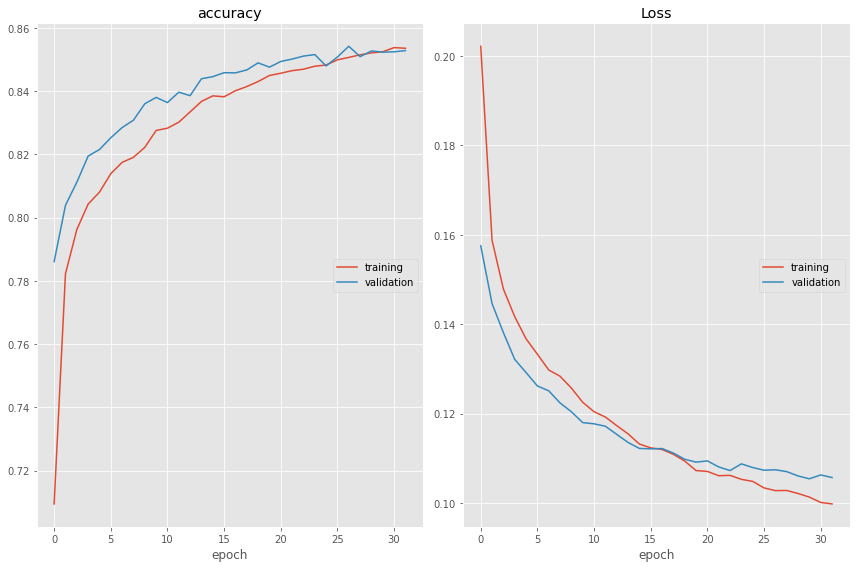

accuracy
	training         	 (min:    0.709, max:    0.854, cur:    0.854)
	validation       	 (min:    0.786, max:    0.854, cur:    0.853)
Loss
	training         	 (min:    0.100, max:    0.202, cur:    0.100)
	validation       	 (min:    0.105, max:    0.158, cur:    0.106)

Epoch 32: val_loss did not improve from 0.10544
56/56 [==============================] - 2s 37ms/step - loss: 0.1071 - accuracy: 0.8488
[0.10712865740060806, 0.8487614989280701]


In [11]:
root_path = 'model/'
model_name = 'w2v_sg_blstm_model.h5'
num_epoch = 50
callbacks = get_callbacks(root_path, model_name)

history = model.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_val, y_val),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose=1
)

print(model.evaluate(X_test, y_test))

In [12]:
from keras.models import load_model

mdl = load_model('model/w2v_sg_blstm_model.h5')

In [13]:
all_w_pair = []
all_true_pair = []
all_pred_pair = []

for i in range(len(X_test)):
    p = mdl.predict(np.array([X_test[i]]))
    p = np.argmax(p, axis=-1)
    y_true = y_test[i]
    w_pair = []
    true_pair = []
    pred_pair = []
    for w, true, pred in zip(X_test[i], y_true, p[0]):
        if words[w-1] != "ENDPAD":
            # print("{:30}{:10}\t{}".format(words[w-1], tags[true], tags[pred]))
            w_pair.append(words[w-1])
            true_pair.append(tags[true])
            pred_pair.append(tags[pred])
    all_w_pair.append(w_pair)
    all_true_pair.append(true_pair)
    all_pred_pair.append(pred_pair)

In [14]:
true_flat = [item for sublist in all_true_pair for item in sublist]
pred_flat = [item for sublist in all_pred_pair for item in sublist]

              precision    recall  f1-score   support

          ID     0.8543    0.9350    0.8928     22309
          JV     0.7880    0.8276    0.8073      4914
          EN     0.8682    0.6916    0.7699      5020
   MIX-ID-EN     0.9286    0.5612    0.6996       973
   MIX-ID-JV     0.9672    0.4214    0.5871       280
   MIX-JV-EN     0.8939    0.5776    0.7018       277
           O     0.8547    0.7962    0.8244     10151

    accuracy                         0.8493     43924
   macro avg     0.8793    0.6872    0.7547     43924
weighted avg     0.8512    0.8493    0.8460     43924



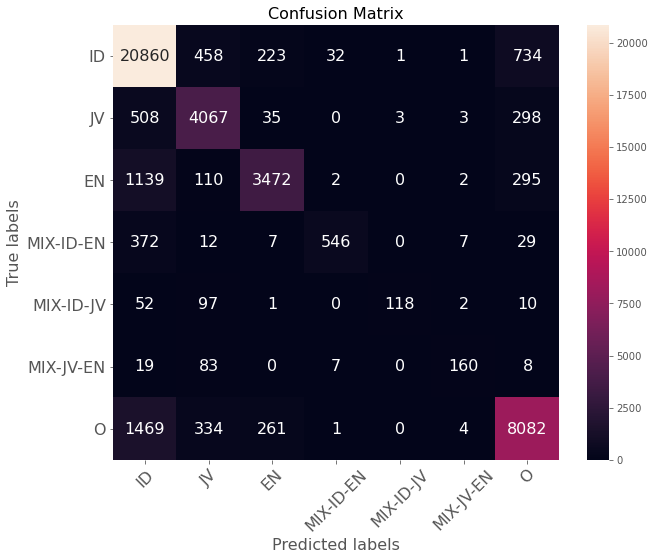

In [15]:
performance_report(true_flat, pred_flat)

In [16]:
df_ = pd.DataFrame({
    'word': all_w_pair,
    'true': all_true_pair,
    'pred': all_pred_pair
})
token_true_pred = []
for index, row in df_.iterrows():
    pair = list(zip(row['word'], row['true'], row['pred']))
    token_true_pred.append(pair)
true_pred_file = 'tagging_result/compare_results_w2v_sg.tsv'
with open(true_pred_file, "a", encoding='utf-8') as f:
    f.write("Word" + "\t" + "True" + "\t" + "Predict" + "\n")

    for index, row in df_.iterrows():
        for tkn, t_true, t_pred in (zip(row['word'], row['true'], row['pred'])):
            f.write(tkn + '\t' + t_true + '\t' + t_pred + '\n')
        f.write('\n')

f.close()

In [17]:
i = np.random.randint(0, X_test.shape[0])  #659
p = mdl.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
y_true = y_test[i]
print("{:30}{:10}\t {}\n".format("Word", "True", "Pred"))
print("-" * 60)

for w, true, pred in zip(X_test[i], y_true, p[0]):
    if words[w - 1] != "ENDPAD":
        print("{:30}{:10}\t{}".format(words[w - 1], tags[true], tags[pred]))

Word                          True      	 Pred

------------------------------------------------------------
oyi                           JV        	O
rek                           JV        	ID
penjual                       ID        	ID
ayam                          ID        	ID
potong                        ID        	ID
di                            ID        	ID
pasar                         ID        	ID
itu                           ID        	ID
mau                           ID        	ID
apa                           ID        	ID
engga                         ID        	ID
ya                            ID        	ID
kalo                          ID        	ID
misal                         ID        	ID
kita                          ID        	ID
beline                        MIX-ID-JV 	MIX-ID-JV
fillet                        EN        	ID
?                             O         	O
spill                         EN        	ID
dipasar                       ID        	ID
mana  

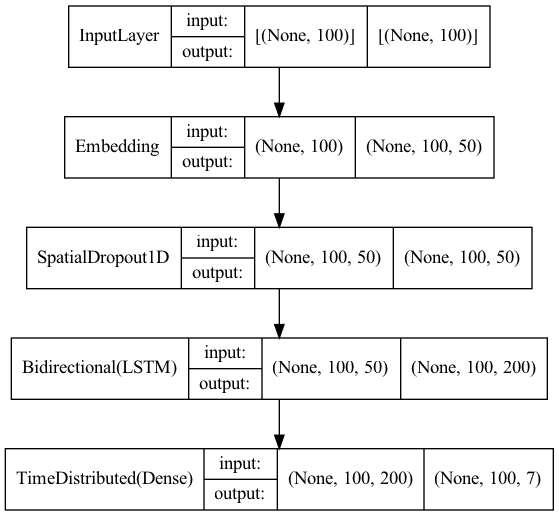

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot/tr_w2v_sg_blstm.png', show_shapes=True, show_layer_names=False)